# Human Activity Recognition

## Group 05

#### Farid Rasulov

In this project we are going to evaluate the performance of several models in classifiying human activity using data recorded with mobile sensors. Despite there are quite a big number of sensors built in smartphones we focused on __'Linear Accelerometer', 'Accelerometer X', 'Accelerometer Y', 'Accelerometer Z','Barometer'__ becuase they are common for a wide range of smartphone models and using the data recorded with this set of sensors is sufficient to distinguish the basic human activities. Data was recorded using Google Science Journal application.

The activity types researched in this project are the following:
__Going downstairs, going upstairs, running, sitting, walking__

Each of the member of our team placed the smartphone with active sensors in the pelvic area and then performed one of the listed activity for a recording.

In [1]:
from os import listdir
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import TimeseriesGenerator
from matplotlib import pyplot as plt
from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

import pprint
pp = pprint.PrettyPrinter(indent=4)

Using TensorFlow backend.


## Contents

[Data_Preprocessing](#Data_Preprocessing)

[Data_Visualization](#Data_Visualization)

[Feature_selection](#Feature_selection)

[Parameter_tuning](#Parameter_tuning)

[Modelling_and_prediction](#Modelling_and_prediction)

[Results](#Results)

<a id='Data_Preprocessing'> Data_Preprocessing</a>

The data obtained from sensors is not clean mainly because of the recording ability of the sensors. Senosrs record data in specific time intervals which depends on sensor type and model of the smartphone. So we imputed all the missing values using interpolation. Then we devided our data to chunks in the size of 2.5 seconds with 50% overlapping. Also we applied fast fourier transformation to the chunk set. 

The following step was to generate a set of features. We decided to extract the following features for each sensor:

__mean, max, min, var, Q1, Q3, slope__

__Slope__ is a feature which show the slope of the obtained data. We considered that it could help the model to distinguish upstairs and downstairs activities. At last all the computed data were concateneted to one dataset

In [2]:
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]
list_csv = find_csv_filenames('Data', suffix='.csv') # List of csv files in our directory

In [3]:
def slope(X):
    return((X[-1]-X[0])/2500) # this function roughly determines the slope

In [4]:
def fft(X):
    return np.abs(np.fft.fft(pd.Series(np.around(X.astype(np.double),2))))

In [5]:
# function for data preprocessing
def datareader(file_dir, name):
    df = pd.read_csv(file_dir) # create dataframe
    sensors = ['timestamp','LinearAccelerometerSensor', 'AccX', 'AccY', 'AccZ','BarometerSensor'] # define list of sensors used
    df = df[sensors].copy() # keep only the sensors defined above
    df['timestamp'] = df['timestamp'] - df['timestamp'].min() # transform the time
    last = df['timestamp'].max() # the last moment of activity
    key = np.array(range(0,last+1)) # create the complete timeline
    key = pd.DataFrame(key)
    df = pd.merge(right=df, left=key, how='left', left_on=0, right_on='timestamp') #expand our dataset to the whole timelines
    df = df[sensors[1:]] # drop the redundant timeline column
    df = df.interpolate() # interpolate the the data in order to fill the missing values
    label = np.empty([len(df.AccX),1], dtype='S10') # creating lable column
    label[:,:] = name # adding the label
    df['label'] = label # adding the labels for the dataframe
    # chunk the data by 2500 milliseconds with 1250 ms overlap (2.5 seconds with 1.25s overlap)
    gen = TimeseriesGenerator(df.values[:,0:-1], df.label.values, length=2500, stride=1250, batch_size=100000000000)
    X, Y = gen[0] # extract the values from generator
    # list of feature names
    cols=[i+j for i in ['Lacc_','AccX_','AccY_','AccZ_','Bar_'] 
                for j in ['mean', 'max', 'min', 'var', 'Q1', 'Q3', 'slope']]
    # create the feature set
    X_data = pd.DataFrame(np.concatenate((np.mean(X, axis=1),
                                          np.max(X, axis=1),
                                          np.min(X, axis=1),
                                          np.var(X, axis=1),
                                          np.percentile(X, 25, axis=1),
                                          np.percentile(X, 75, axis=1),
                                          np.apply_along_axis(slope, axis=1, arr = X)), axis=1), columns=cols)
    X_f = np.apply_along_axis(fft, axis=1, arr=X)
    
    cols_f=[i+j for i in ['Lacc_f_','AccX_f_','AccY_f_','AccZ_f_','Bar_f_'] 
                  for j in ['mean', 'max', 'min', 'var', 'Q1', 'Q3', 'slope']]
    # create the feature set
    X_f_data = pd.DataFrame(np.concatenate((np.mean(X_f, axis=1),
                                          np.max(X_f, axis=1),
                                          np.min(X_f, axis=1),
                                          np.var(X_f, axis=1),
                                          np.percentile(X, 25, axis=1),
                                          np.percentile(X, 75, axis=1),
                                          np.apply_along_axis(slope, axis=1, arr = X_f)), axis=1), columns=cols_f)
    X_data = pd.concat([X_data,X_f_data], axis = 1)
    Y_data = pd.DataFrame(Y) # predicting variable (the type of activity)
    Data = pd.concat([X_data, Y_data], axis=1).dropna() # drop the rest of missing values   
    return(Data)

In [6]:
# reading csv files, extracting the features and concatinating them into dataframe
for i,file_path in enumerate(list_csv):
    file_dir = 'Data/' + file_path
    label = file_dir.split('/')[1].split(' ')[0]
    if i == 0:
        df = datareader(file_dir, label)
    else:
        df = pd.concat([df, datareader(file_dir, label)])

C:\Users\Farid\Anaconda33\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<a id='Data_Visualization'> Data_Visualization</a>

In this part of the project we are going to visualize how our data is clustered. Because of that there are 5 dimensions in our dataset we choosed PCA method to visualize it. PCA is effected by scale so we need to scale the features in the data before applying PCA.The explained variance tells us how much information (variance) can be attributed to each of the principal components. So from the screeplot we can conclude that the major part of the data is attributed to the first principal component. We choosed PC_1 and PC_2 to visualize the data.

In [7]:
def encoder(train, test):
    enc = LabelEncoder()
    enc.fit(train)
    return enc.transform(test)

In [8]:
# changing the types of the columns to the numeric one
X_data = df.iloc[:,0:-1].apply(pd.to_numeric, errors='ignore')#.values
Y_data = df.iloc[:,-1].apply(pd.to_numeric, errors='ignore')#.values

C:\Users\Farid\Anaconda33\lib\site-packages\sklearn\preprocessing\data.py:180: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\Farid\Anaconda33\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


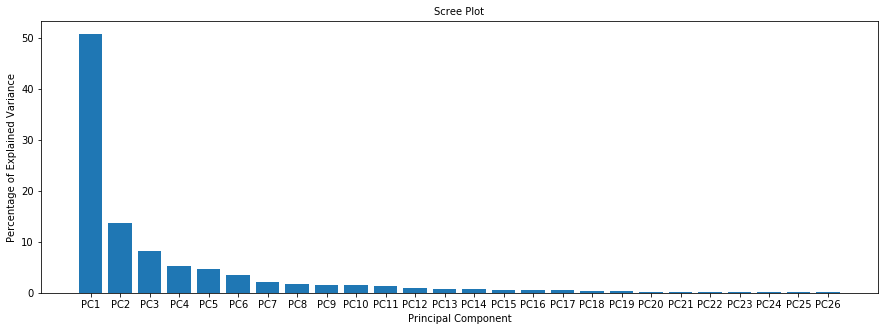

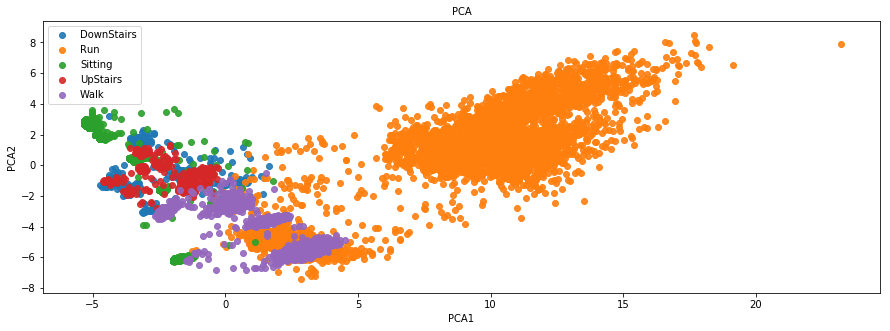

In [10]:
scaled_data = preprocessing.scale(X_data.values)
 
pca = PCA() # create a PCA object
pca.fit(scaled_data) # do the math
pca_data = pca.transform(scaled_data) # get PCA coordinates for scaled_data

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
per_var = per_var[per_var > 0]
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

fig = plt.figure(figsize=(15,5))
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance',fontsize=10)
plt.xlabel('Principal Component',fontsize=10)
plt.title('Scree Plot',fontsize=10)
fig.show()
#fig.savefig('ScreePlot.png')
col = encoder(Y_data, Y_data)

fig = plt.figure(figsize=(15,5))
for i in range(0,5):
    plt.scatter(pca_data[col==i,0], pca_data[col==i,1], alpha=0.9)

plt.legend(labels=['DownStairs', 'Run', 'Sitting', 'UpStairs', 'Walk'],fontsize=10)
plt.xlabel('PCA1',fontsize=10)
plt.ylabel('PCA2',fontsize=10)
plt.title('PCA',fontsize=10)
fig.show()
#fig.savefig('PCA.png')

As it can be seen on the plot above most of the points is for the Running activity. Other activities have relatively equal number of points. However the data is not clusterized. Below is printed the rank of 10 most important features according to their loading scores.

In [11]:
loading_scores = pd.Series(pca.components_[0], index=list(X_data))
sorted_loading_scores = (loading_scores.abs()).sort_values(ascending=False)
top = sorted_loading_scores[0:10].index.values
print(sorted_loading_scores[top])

Lacc_mean       0.164418
Lacc_f_Q3       0.164418
Bar_f_min       0.164096
AccZ_f_Q1       0.163630
AccZ_Q1         0.163630
Lacc_f_min      0.161670
Lacc_Q3         0.161518
AccY_f_slope    0.160563
AccY_slope      0.160563
AccX_Q3         0.160445
dtype: float64


In [12]:
# split the preprocessed data into train and test set with rate 70%
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, train_size = .7)
Y_train_enc = encoder(Y_train, Y_train)
Y_test_enc = encoder(Y_train, Y_test)

C:\Users\Farid\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


<a id='Feature_selection'> Feature_selection</a>

Feature selection were provided using built in algorithm of Random Forest Classifier. After obtaining the importance score for each feature we select those of them which score was above 0.01.

C:\Users\Farid\Anaconda33\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Text(0.5, 1.0, 'Importance of Features')

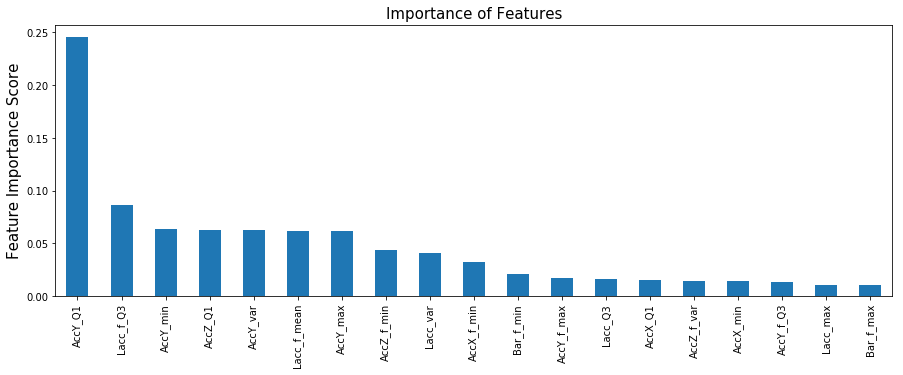

In [21]:
# Feature importance rank
rffs = RandomForestClassifier()
rffs.fit(X_train, Y_train_enc)
imp = pd.Series(rffs.feature_importances_, X_train.columns).sort_values(ascending=False)
(imp[imp>0.01]).plot(kind='bar', figsize=(15,5), fontsize = 10)
plt.ylabel('Feature Importance Score', fontsize = 15)
plt.title('Importance of Features', fontsize = 15)
#fig = plt.gcf()
#fig.savefig('FeaturImportance.png')

In [22]:
rffs_selection = list(imp[imp > 0.01].index)
X_train_rffs = X_train[rffs_selection]
X_test_rffs = X_test[rffs_selection]

<a id='Parameter_tuning'> Parameter_tuning</a>

We are going to train three models on our data __RandomForestClassifier(), GradientBoostingClassifier(), MLPClassifier()__ . First of all we need to define the optimal set of parameters for each model. Using Scikit-Learn’s RandomizedSearchCV method, we can define a grid of hyperparameter ranges, and randomly sample from the grid, performing K-Fold CV with each combination of values. We are computing the best parameters for the models trained both on the full set of features and on the reduced feature set.

Performing parameter tuning for Random Forest Classifier:

In [23]:
print('Set a random grid')
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 500, num = 4)],# Number of trees in random forest
               'max_features': ['auto', 'sqrt'], # Number of features to consider at every split
               'max_depth': [int(x) for x in np.linspace(10, 50, num = 4)], # Maximum number of levels in tree
               'min_samples_split': [2, 4, 6], # Minimum number of samples required to split a node
               'min_samples_leaf': [1, 2, 4], # Minimum number of samples required at each leaf node
               'bootstrap': [True, False] # Method of selecting samples for training each tree
              }

# tuning the parameters
rf_random_full = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_grid, 
                                               n_iter = 5, cv = 3, random_state=42, n_jobs = -1)

rf_random_rffs = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_grid, 
                                               n_iter = 5, cv = 3, random_state=42, n_jobs = -1)
print('Train model on a full feature set')
rf_random_full.fit(X_train.values, Y_train_enc)
print('Train model on a rffs feature set')
rf_random_rffs.fit(X_train_rffs.values, Y_train_enc)
print('Done')

Set a random grid
Train model on a full feature set
Train model on a rffs feature set
Done


In [24]:
print('Best parameters for the full feature set:\n')
pp.pprint(rf_random_full.best_params_)
print('Best parameters for the rffs feature set:\n')
pp.pprint(rf_random_rffs.best_params_)

Best parameters for the full feature set:

{   'bootstrap': False,
    'max_depth': 36,
    'max_features': 'auto',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 500}
Best parameters for the rffs feature set:

{   'bootstrap': False,
    'max_depth': 36,
    'max_features': 'auto',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 500}


Performing parameter tuning for Gradient Boosting Classifier:

In [25]:
print('Set a random grid')
random_grid = {
               'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 500, num = 4)], # Number of trees in random forest
               'max_features': ['auto', 'sqrt'], # Number of features to consider at every split
               'max_depth': [int(x) for x in np.linspace(1, 10, num = 4)], # Maximum number of levels in tree
               'min_samples_split': [2, 4], # Minimum number of samples required to split a node
               'min_samples_leaf': [1, 2], # Minimum number of samples required at each leaf node
            }

gb_random_full = RandomizedSearchCV(estimator=GradientBoostingClassifier(), param_distributions=random_grid,
                                               n_iter=5, cv=3, random_state=42, n_jobs=-1)

gb_random_rffs = RandomizedSearchCV(estimator=GradientBoostingClassifier(), param_distributions=random_grid,
                                               n_iter=5, cv=3, random_state=42, n_jobs=-1)

print('Train model on a full feature set')
gb_random_full.fit(X_train.values, Y_train_enc)
print('Train model on a rffs feature set')
gb_random_rffs.fit(X_train_rffs.values, Y_train_enc)
print('Done')

Set a random grid
Train model on a full feature set
Train model on a rffs feature set
Done


In [26]:
print('Best parameters for the full feature set:\n')
pp.pprint(gb_random_full.best_params_)
print('Best parameters for the rffs feature set:\n')
pp.pprint(gb_random_rffs.best_params_)

Best parameters for the full feature set:

{   'max_depth': 4,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 4,
    'n_estimators': 500}
Best parameters for the rffs feature set:

{   'max_depth': 4,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 4,
    'n_estimators': 500}


Performing parameter tuning for MLP Classifier:

In [27]:
# we need to scale the predictors before using it in MLP Classifier
scaler = MinMaxScaler() # define scaler
scaler.fit(X_train)
X_tr_t = scaler.transform(X_train) # scale the training set
X_ts_t = scaler.transform(X_test) # scale the test set
scaler.fit(X_train_rffs)
X_tr_t_rffs = scaler.transform(X_train_rffs) # scale the training set
X_ts_t_rffs = scaler.transform(X_test_rffs) # scale the test set

In [28]:
print('Set a random grid')
random_grid = {  
                'solver' : ['lbfgs', 'sgd', 'adam'],#The solver for weight optimization.
                                    #‘lbfgs’ is an optimizer in the family of quasi-Newton methods.
                                    #‘sgd’ refers to stochastic gradient descent.
                                    #‘adam’ refers to a stochastic gradient-based optimizer
                'max_iter': [1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000 ],#Maximum number of iterations. 
                                                            #The solver iterates until convergence (determined by ‘tol’) or 
                                                            #this number of iterations. For stochastic solvers (‘sgd’, ‘adam’), 
                                                            #note that this determines the number of epochs (how many times each 
                                                            #data point will be used), not the number of gradient steps. 
                'alpha': 10.0 ** -np.arange(1, 10), #L2 penalty (regularization term) parameter.
                'hidden_layer_sizes':[(50,50,50,50), (100,100,100,100)] #The ith element represents the number of neurons in the ith hidden layer.
            }

mlp_random_full = RandomizedSearchCV(estimator= MLPClassifier(verbose=False), param_distributions=random_grid,
                                               n_iter=5, cv=3, random_state=42, n_jobs=-1)

mlp_random_rffs = RandomizedSearchCV(estimator= MLPClassifier(verbose=False), param_distributions=random_grid,
                                               n_iter=5, cv=3, random_state=42, n_jobs=-1)

print('Train model on a full feature set')
mlp_random_full.fit(X_tr_t, Y_train_enc)
print('Train model on a rffs feature set')
mlp_random_rffs.fit(X_train_rffs, Y_train_enc)
print('Done')

Set a random grid
Train model on a full feature set
Train model on a rffs feature set
Done


In [29]:
print('Best parameters for the full feature set:\n')
pp.pprint(mlp_random_full.best_params_)
print('Best parameters for the rffs feature set:\n')
pp.pprint(mlp_random_rffs.best_params_)

Best parameters for the full feature set:

{   'alpha': 1e-07,
    'hidden_layer_sizes': (100, 100, 100, 100),
    'max_iter': 1200,
    'solver': 'lbfgs'}
Best parameters for the rffs feature set:

{   'alpha': 0.01,
    'hidden_layer_sizes': (100, 100, 100, 100),
    'max_iter': 1100,
    'solver': 'lbfgs'}


<a id='Modelling_and_prediction'> Modelling_and_prediction</a>

After defining the optimal parameters for each model we are going to train the models using k_fold cross validation.

In [30]:
def k_fold(model, X_data, Y_data, scale = False):        
    kf = KFold(n_splits = 5, shuffle=True)
    Y_data_enc = encoder(Y_data, Y_data)
    i = 0
    for tr_ind,te_ind in kf.split(X_data.values):
        if scale == True : 
            scaler = MinMaxScaler() # define scaler
            scaler.fit(X_data.values[tr_ind,:])
            X_train = scaler.transform(X_data.values[tr_ind,:])   # scale the training set
            X_test = scaler.transform(X_data.values[te_ind,:])   # scale the test set
        else:
            X_train = X_data.values[tr_ind,:]
            X_test = X_data.values[te_ind,:]
            
        model.fit(X_train, Y_data_enc[tr_ind])
        if i == 0:
            Y_pred = model.predict(X_test)
            Y_true = Y_data_enc[te_ind]
            i +=1
        else:
            Y_pred = np.concatenate((Y_pred, model.predict(X_data.values[te_ind,:])))
            Y_true = np.concatenate((Y_true,  Y_data_enc[te_ind]))
            i +=1
    return {'True':Y_true, 'Prediction':Y_pred}

In [31]:
def prediction(output):
    activity = ['DownStairs', 'Run', 'Sitting', 'UpStairs', 'Walk']
    print(pd.DataFrame(confusion_matrix(output['True'], output['Prediction']), index = activity, columns = activity))
    print(classification_report(output['True'], output['Prediction'],target_names=activity))
    print("accuracy_score: ", accuracy_score(output['True'], output['Prediction']))

Random Forest Classifier

In [32]:
rf_full = RandomForestClassifier(**rf_random_full.best_params_)
rf_rffs = RandomForestClassifier(**rf_random_rffs.best_params_)
output_rf_full = k_fold(rf_full, X_data, Y_data)
output_rf_rffs = k_fold(rf_rffs, X_data, Y_data)

In [33]:
prediction(output_rf_full)

            DownStairs   Run  Sitting  UpStairs  Walk
DownStairs         394     0        0         2     0
Run                  0  4249        0         0     1
Sitting              2     0     9211         2     3
UpStairs             3     0        0       336     0
Walk                 0     3        0         0  1715
              precision    recall  f1-score   support

  DownStairs       0.99      0.99      0.99       396
         Run       1.00      1.00      1.00      4250
     Sitting       1.00      1.00      1.00      9218
    UpStairs       0.99      0.99      0.99       339
        Walk       1.00      1.00      1.00      1718

   micro avg       1.00      1.00      1.00     15921
   macro avg       0.99      1.00      1.00     15921
weighted avg       1.00      1.00      1.00     15921

accuracy_score:  0.9989950380001256


In [34]:
prediction(output_rf_rffs)

            DownStairs   Run  Sitting  UpStairs  Walk
DownStairs         393     0        0         3     0
Run                  0  4248        0         0     2
Sitting              2     0     9210         2     4
UpStairs             3     0        0       336     0
Walk                 0     5        0         0  1713
              precision    recall  f1-score   support

  DownStairs       0.99      0.99      0.99       396
         Run       1.00      1.00      1.00      4250
     Sitting       1.00      1.00      1.00      9218
    UpStairs       0.99      0.99      0.99       339
        Walk       1.00      1.00      1.00      1718

   micro avg       1.00      1.00      1.00     15921
   macro avg       0.99      1.00      0.99     15921
weighted avg       1.00      1.00      1.00     15921

accuracy_score:  0.9986809873751649


Gradient Boosting Classifier

In [35]:
gb_full = GradientBoostingClassifier(**gb_random_full.best_params_)
gb_rffs = GradientBoostingClassifier(**gb_random_rffs.best_params_)
output_gb_full = k_fold(gb_full, X_data, Y_data)
output_gb_rffs = k_fold(gb_rffs, X_data, Y_data)

In [36]:
prediction(output_gb_full)

            DownStairs   Run  Sitting  UpStairs  Walk
DownStairs         388     1        0         7     0
Run                  0  4249        0         0     1
Sitting              1     0     9210         3     4
UpStairs             8     0        0       331     0
Walk                 0     0        0         0  1718
              precision    recall  f1-score   support

  DownStairs       0.98      0.98      0.98       396
         Run       1.00      1.00      1.00      4250
     Sitting       1.00      1.00      1.00      9218
    UpStairs       0.97      0.98      0.97       339
        Walk       1.00      1.00      1.00      1718

   micro avg       1.00      1.00      1.00     15921
   macro avg       0.99      0.99      0.99     15921
weighted avg       1.00      1.00      1.00     15921

accuracy_score:  0.9984297468751963


In [37]:
prediction(output_gb_rffs)

            DownStairs   Run  Sitting  UpStairs  Walk
DownStairs         392     0        0         4     0
Run                  0  4249        0         0     1
Sitting              4     0     9208         2     4
UpStairs             8     0        1       330     0
Walk                 0     0        0         0  1718
              precision    recall  f1-score   support

  DownStairs       0.97      0.99      0.98       396
         Run       1.00      1.00      1.00      4250
     Sitting       1.00      1.00      1.00      9218
    UpStairs       0.98      0.97      0.98       339
        Walk       1.00      1.00      1.00      1718

   micro avg       1.00      1.00      1.00     15921
   macro avg       0.99      0.99      0.99     15921
weighted avg       1.00      1.00      1.00     15921

accuracy_score:  0.9984925570001885


MLP Classifier

In [38]:
mlp_full = MLPClassifier(**mlp_random_full.best_params_)
mlp_rffs = MLPClassifier(**mlp_random_rffs.best_params_)
output_mlp_full = k_fold(mlp_full, X_data, Y_data)
output_mlp_rffs = k_fold(mlp_rffs, X_data, Y_data)

In [39]:
prediction(output_mlp_full)

            DownStairs  Run  Sitting  UpStairs  Walk
DownStairs         166    0      160        70     0
Run               1707    0     1689       854     0
Sitting           3655    0     3697      1866     0
UpStairs           154    0      136        49     0
Walk               687    0      686       345     0
              precision    recall  f1-score   support

  DownStairs       0.03      0.42      0.05       396
         Run       0.00      0.00      0.00      4250
     Sitting       0.58      0.40      0.47      9218
    UpStairs       0.02      0.14      0.03       339
        Walk       0.00      0.00      0.00      1718

   micro avg       0.25      0.25      0.25     15921
   macro avg       0.12      0.19      0.11     15921
weighted avg       0.34      0.25      0.28     15921

accuracy_score:  0.24571320896928586


C:\Users\Farid\Anaconda33\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [40]:
prediction(output_mlp_rffs)

            DownStairs   Run  Sitting  UpStairs  Walk
DownStairs           0    81        0       158   157
Run                  0   823        0      1694  1733
Sitting              0  1864        0      3662  3692
UpStairs             0    69        0       148   122
Walk                 0   347        0       706   665
              precision    recall  f1-score   support

  DownStairs       0.00      0.00      0.00       396
         Run       0.26      0.19      0.22      4250
     Sitting       0.00      0.00      0.00      9218
    UpStairs       0.02      0.44      0.04       339
        Walk       0.10      0.39      0.16      1718

   micro avg       0.10      0.10      0.10     15921
   macro avg       0.08      0.20      0.09     15921
weighted avg       0.08      0.10      0.08     15921

accuracy_score:  0.10275736448715533


<a id='Results'> Results</a>

As we can see the predictive abilities of Random Forest and Gradient Boosting Classifiers are very strong. The accuracy score for these models is near 99%. From confusion matrix it can be seen that the minor number of mistakes is made while distinguishing Downstairs and Upstairs activities. These models give a good results even on a reduced set of selected features. So in order to optimize the computation we can train model on the smaller feature set. MLP Classifier failed to recognize activities.   